# Credible Concept Model (CCM) tutorial: Extend credible model to uninterpretable raw features

By the end of the tutorial, one should be able to

1. understand the motivation of CCM
2. understand the CCM algorithm
3. able to train an CCM model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

# A motivating example

Despite the fact that model interpretation suffers from faithfulness and fragility issues (and also people's overtrust of the interpretation), it is still useful to enforce prior knowledge. Feature attribution tools often assume that features are interpretable. This makes them less applicable when raw features are complicated (say in the image or audio domain). Thus, a lot of recent research effort have been poured in to explanation with high level concepts. Among them is this idea of concept bottleneck network (CBM). In this work, we expose the flaw of CBM and suggest a simple fix.

This examples shows why missing concept is a nastier problem than one would think.

$Z \sim U(\{0, 1\})^d$ are $d$ latent concepts

$X = project(Z)$ is a random linear projection of concepts presented to the human (the following just used identity for simplicity)

$X \rightarrow C \rightarrow X$ where $C \in \mathbb{R}^{d-1}$ is concept detectors

$Y = and(Z)$ where $\theta$ is the true coefficient.

This setup will fail raw feature attribution (because $X$ distribute concepts across dimensions), concept discovery (when the function is a "and" concept), jointly trained concept (because $C$ has 1 less dimension off $Z$).

In [2]:
n = 10000
d = 3 # true number of concepts needed for classification
bs = 100
n_concepts = 1 # number concepts to learn for EBM
n_epochs = 100
top_n = 10 # number of nearest neibhor examples to show

def gen_data(n, d):
    Z = np.random.choice([0, 1], (n, d))
    X = Z
    # and of the arguments
    Y = np.ones(n)
    for i in range(d):
        Y = np.logical_and(Y, Z[:, i])

    return torch.from_numpy(X).float(), torch.from_numpy(Y).long(), torch.from_numpy(Z).float()

X, Y, Z = gen_data(n, d)
X_te, Y_te, Z_te = gen_data(n, d)
print(f'Percentage of ones {(1-0.5**d)*100:.2f}%')

Percentage of ones 87.50%


In [3]:
class MLP(nn.Module):

    def __init__(self, neuron_sizes, activation=nn.ReLU, bias=True): 
        super(MLP, self).__init__()
        self.neuron_sizes = neuron_sizes
        
        layers = []
        for s0, s1 in zip(neuron_sizes[:-1], neuron_sizes[1:]):
            layers.extend([
                nn.Linear(s0, s1, bias=bias),
                activation()
            ])
        
        self.classifier = nn.Sequential(*layers[:-1])
        
    def forward(self, x):
        x = x.view(-1, self.neuron_sizes[0])
        return self.classifier(x)
    
def plot_log(log, key="loss"):
    '''log is train log [{epoch: xxx, loss: xxx}]'''
    x = [item['epoch'] for item in log]
    y = [item[key] for item in log]
    plt.semilogy(x, y)
    plt.xlabel('epochs', fontsize=15)
    plt.ylabel(key, fontsize=15)
    plt.plot()
    
def train_step_standard(net, loader, opt, criterion, device='cpu'):
    losses = []
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        opt.zero_grad()
        o = net(x)
        l = criterion(o, y).mean()
        l.backward()
        opt.step()
        losses.append(l.detach().item())
    return losses
    
def train(net, loader, opt, train_step=train_step_standard, 
          criterion=F.cross_entropy, n_epochs=10, report_every=1,
          device="cpu"):
    net.train()
    train_log, losses = [], []

    for i in range(n_epochs):
        
        _losses = train_step(net, loader, opt, criterion, device=device)
        losses.extend(_losses)
        
        train_report = {"loss": np.mean(losses[-len(loader):])}
        
        if (i+1) % report_every == 0: # report loss
            print('epoch {:>3}: '.format(i) + ' '.join('{} {:.3e}'.format(
                      name, val
                  ) for name, val in train_report.items()))

        train_report.update({'epoch': i})
        train_log.append(train_report)

    return train_log    
    
def test(net, loader, criterion):
    net.eval()
    losses = []
    total = 0
    for x, y in loader:
        o = net(x)
        l = criterion(o, y).mean()
        bs = o.shape[0]
        total += bs        
        losses.append(l.detach().item() * bs)
    net.train()
    return sum(losses) / total

# report accuracy
acc_criterion = lambda o, y: (o.argmax(1) == y).float()

# dataset
loader_xy = DataLoader(TensorDataset(X, Y), batch_size=bs, shuffle=True) # regular dataset
loader_xyz = DataLoader(TensorDataset(X, Y, Z), batch_size=bs, shuffle=True) # joint concept and regular dataset

loader_xy_te = DataLoader(TensorDataset(X_te, Y_te), batch_size=bs, shuffle=True) # regular dataset
loader_xyz_te = DataLoader(TensorDataset(X_te, Y_te, Z_te), batch_size=bs, shuffle=True) # joint concept and regular dataset

## standard model

/home/jiaxuan/.local/share/virtualenvs/CredibleConceptModel-7quSdsQm/lib/python3.7/site-packages/torch/autograd/__init__.py:147: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  allow_unreachable=True, accumulate_grad=True)  # allow_unreachable flag


epoch   9: loss 1.188e-01
epoch  19: loss 3.046e-02
epoch  29: loss 9.731e-03
epoch  39: loss 3.933e-03
epoch  49: loss 1.816e-03
epoch  59: loss 9.057e-04
epoch  69: loss 4.730e-04
epoch  79: loss 2.546e-04
epoch  89: loss 1.398e-04
epoch  99: loss 7.787e-05


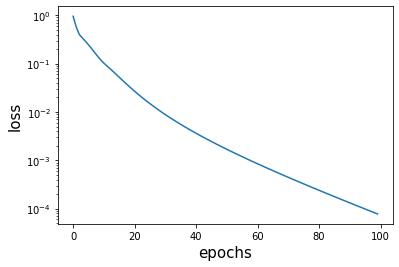

In [4]:
def standard_model(loader_xy, d, n_epochs=10, report_every=1, plot=True):
    # regular model
    net = MLP([d, d * 2, 2])

    # train
    opt = optim.Adam(net.parameters())
    log = train(net, loader_xy, opt, n_epochs=n_epochs, report_every=report_every)
    if plot: plot_log(log)
    return net

standard_net = standard_model(loader_xy, d, n_epochs=n_epochs, report_every=n_epochs//10)

In [5]:
print('task acc after training: {:.1f}%'.format(test(standard_net, loader_xy_te, acc_criterion) * 100))

task acc after training: 100.0%


## joint EBM

number of concepts to learn: 1
true number of concepts: 3
epoch   9: loss 2.862e-03
epoch  19: loss 1.196e-03
epoch  29: loss 5.451e-04
epoch  39: loss 2.622e-04
epoch  49: loss 1.330e-04
epoch  59: loss 7.138e-05
epoch  69: loss 4.004e-05
epoch  79: loss 2.305e-05
epoch  89: loss 1.351e-05
epoch  99: loss 8.025e-06


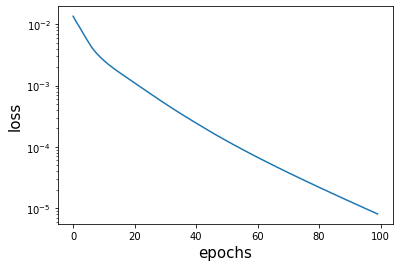

In [6]:
class EBM(nn.Module):
    '''
    net_c is concept net, net_y is the task net
    it output net_y(net_c(x))
    '''

    def __init__(self, net_c, net_y): 
        super(EBM, self).__init__()
        self.net_c = net_c
        self.net_y = net_y
        
        self.classifier = nn.Sequential(net_c, net_y)
        
    def forward(self, x):
        return self.classifier(x)

def train_step_xyz(net, loader, opt, criterion, device='cpu'):
    '''training step for EBM jont model'''
    assert type(net) == EBM, f"must use EBM model; currently {type(net)}"
    losses = []
    for x, y, z in loader:
        x, y, z = x.to(device), y.to(device), z.to(device)
        opt.zero_grad()
        o_z = net.net_c(x)
        o_y = net.net_y(o_z)
        l = criterion(o_y, y, o_z, z).mean()
        l.backward()
        opt.step()
        losses.append(l.detach().item())
    return losses

def joint_EBM(d, n_concepts, loader_xyz, n_epochs=10, report_every=1, plot=True):
    n_concepts = min(d, n_concepts)
    print(f'number of concepts to learn: {n_concepts}')
    print(f'true number of concepts: {d}')
    
    # EBM with concept and task jointly trained
    net_c = MLP([d, d * 2, n_concepts])
    net_y = MLP([n_concepts, d * 2, 2])
    net = EBM(net_c, net_y)
    
    # train
    def criterion(o_y, y, o_z, z):
        y_loss = F.cross_entropy(o_y, y).sum()
        z_loss = F.binary_cross_entropy(torch.sigmoid(o_z), z[:, :n_concepts]).sum()
        return (y_loss + z_loss) / len(y)
    
    opt = optim.Adam(net.parameters())
    log = train(net, loader_xyz, opt, train_step=train_step_xyz, 
                criterion=criterion, n_epochs=n_epochs, report_every=report_every)
    if plot: plot_log(log)
    
    return net

ebm_joint = joint_EBM(d, n_concepts, loader_xyz, n_epochs=n_epochs, report_every=n_epochs//10)

In [7]:
# todo: clean: now assumes net_c output binary prediction
def test_concept(net, concept_idx, loader):
    '''net output many logit for concepts, concept_idx is the concept index'''
    net.eval()
    losses = []
    total = 0
    for x, y in loader:
        o = net(x) # (bs, n_concepts)
        o2 = torch.sigmoid(o[:, concept_idx]) > 0.5
        l = (o2 == y).float().mean()
        bs = o.shape[0]
        total += bs        
        losses.append(l.detach().item() * bs)
    net.train()
    return sum(losses) / total

def print_concept_acc(net_c, n_concepts, X_te, Z_te):
    for i in range(n_concepts):
        print('concept {} acc after training: {:.1f}%'.format(i, test_concept(net_c,
                                                                              i,
                                                                              DataLoader(TensorDataset(X_te, Z_te[:, i]), batch_size=bs)) * 100))

print('task acc after training: {:.1f}%'.format(test(ebm_joint, loader_xy_te, acc_criterion ) * 100))
print_concept_acc(ebm_joint.net_c, n_concepts, X_te, Z_te)

task acc after training: 100.0%
concept 0 acc after training: 100.0%


Jointly EBM is troublesome because it packed more than one concept into its concept detector; It should not have perfect task accuracy!

**This also shows that the concept completness score measure would fail because the jointly discovered concepts can fool people. Here we show top 10 instances that best activate the concept detector. One observes that looking at nearest neighbor concepts is not able to spot any problem in this pipeline.**

In [8]:
def get_output(net, loader_x):
    o = []
    for x, in loader_x:
        o.extend(net(x).detach().numpy())
    return np.vstack(o) # (n, n_concepts)

prediction = get_output(ebm_joint.net_c, 
                        DataLoader(TensorDataset(X), batch_size=bs, shuffle=False))
for i in range(n_concepts):
    print(f'Top {top_n} input that most activate concept {i} are:')
    top_idx = np.argsort(prediction[:, i])[-top_n:]
    print(X[top_idx])

Top 10 input that most activate concept 0 are:
tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])


## independent EBM

number of concepts to learn: 1
true number of concepts: 3
training concepts ...
epoch   9: loss 1.035e-01
epoch  19: loss 1.558e-02
epoch  29: loss 4.940e-03
epoch  39: loss 2.065e-03
epoch  49: loss 9.817e-04
epoch  59: loss 5.005e-04
epoch  69: loss 2.659e-04
epoch  79: loss 1.449e-04
epoch  89: loss 8.035e-05
epoch  99: loss 4.508e-05
training tasks ...
epoch   9: loss 2.894e-01
epoch  19: loss 2.795e-01
epoch  29: loss 2.780e-01
epoch  39: loss 2.772e-01
epoch  49: loss 2.770e-01
epoch  59: loss 2.768e-01
epoch  69: loss 2.768e-01
epoch  79: loss 2.767e-01
epoch  89: loss 2.767e-01
epoch  99: loss 2.766e-01


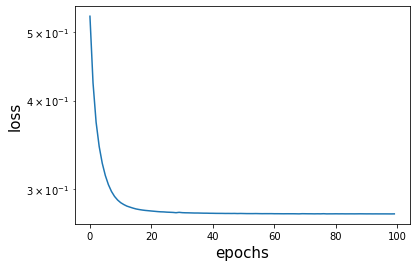

In [9]:
def ind_EBM(d, n_concepts, X, Y, Z, n_epochs=10, report_every=1, plot=True):
    n_concepts = min(d, n_concepts)
    print(f'number of concepts to learn: {n_concepts}')
    print(f'true number of concepts: {d}')
    
    # EBM with concept and task independently trained
    net_c = nn.Sequential(MLP([d, d * 2, n_concepts]), nn.Sigmoid())
    net_y = MLP([n_concepts, d * 2, 2])
    net = EBM(net_c, net_y)
    
    # train
    print('training concepts ...')
    opt_c = optim.Adam(net_c.parameters())
    train(net_c, 
          DataLoader(TensorDataset(X, Z[:, :n_concepts]), batch_size=bs, shuffle=True), 
          opt_c, criterion=nn.BCELoss(), n_epochs=n_epochs, report_every=report_every)

    print('training tasks ...')
    opt_y = optim.Adam(net_y.parameters())
    log = train(net_y, 
                DataLoader(TensorDataset(Z[:, :n_concepts], Y), batch_size=bs, shuffle=True), 
                opt_y, n_epochs=n_epochs, report_every=report_every)
    if plot: plot_log(log)

    return net

ebm_ind = ind_EBM(d, n_concepts, X, Y, Z, n_epochs=n_epochs, report_every=n_epochs//10)

In [10]:
print('task acc after training: {:.2f}%'.format(test(ebm_ind, loader_xy_te, acc_criterion ) * 100)) # the optimum is 1/16 + 3/4; the strategy is to randomize if the first concept is 1, otherwise output 0
print_concept_acc(ebm_ind.net_c[0], n_concepts, X_te, Z_te) # net_c[0] because it is the logit part

task acc after training: 87.54%
concept 0 acc after training: 100.0%


In [11]:
prediction = get_output(ebm_ind.net_c, 
                        DataLoader(TensorDataset(X), batch_size=bs, shuffle=False))
for i in range(n_concepts):
    print(f'Top {top_n} input that most activate concept {i} are:')
    top_idx = np.argsort(prediction[:, i])[-top_n:]
    print(X[top_idx])

Top 10 input that most activate concept 0 are:
tensor([[1., 1., 0.],
        [1., 1., 0.],
        [1., 1., 0.],
        [1., 1., 0.],
        [1., 1., 0.],
        [1., 1., 0.],
        [1., 1., 0.],
        [1., 1., 0.],
        [1., 1., 0.],
        [1., 1., 0.]])


## theoretical limit of limited concepts

In [ ]:
1

## EBM sequential